In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import nltk
import pickle
from nltk.stem import WordNetLemmatizer

from yellowbrick.text.freqdist import FreqDistVisualizer 

%matplotlib inline

In [2]:
# dataset is taken from Kaggle website
df_train = pd.read_csv('./dataset/train.csv')
df_test = pd.read_csv('./dataset/test.csv')

In [3]:
# train data
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# test data . Note: it does not have target and just can be used for testing
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
print('missing values of keyword: {}/{} ({}%)'.
      format(df_train.keyword.isna().sum(),len(df_train),round((df_train.keyword.isna().sum() / len(df_train)) * 100,2)))

missing values of keyword: 61/7613 (0.8%)


In [6]:
print('missing values of location: {}/{} ({}%)'.
      format(df_train.location.isna().sum(), len(df_train),round((df_train.location.isna().sum() / len(df_train)) * 100,2)))

missing values of location: 2533/7613 (33.27%)


In [7]:
# the number of classes are almost balanced and we do not need to balance them.
df_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

we are going to drop the columns which have missing values as well as ID. 
ID does not add any value to the model that we are going to create.

In [8]:
df_train.drop(['id','location', 'keyword'], axis=1, inplace=True)

In [9]:
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


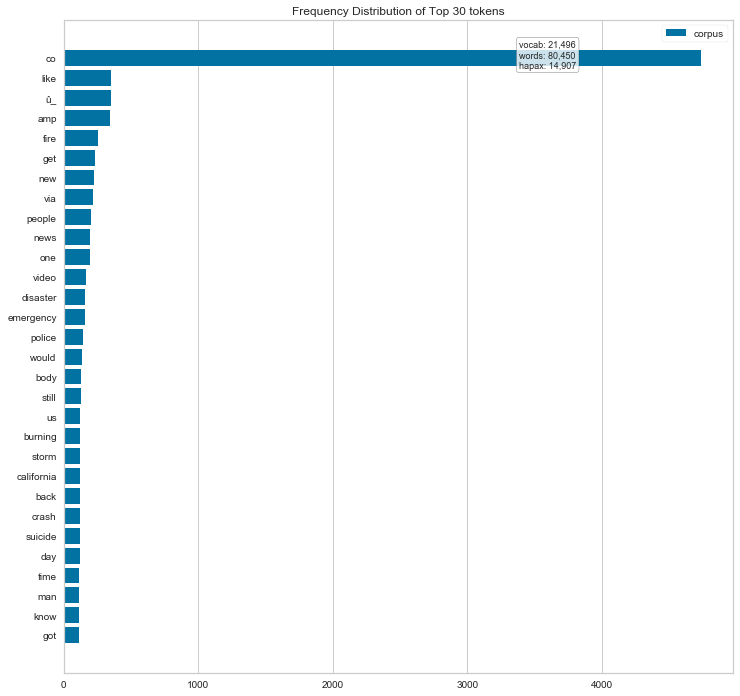

In [10]:
# Find the Document Term Frequency Matrix
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['http','https']
stopwords.extend(newStopWords)

vect = CountVectorizer(stop_words=stopwords)
X = vect.fit_transform(df_train['text'])

# Get all features (tokens)
features = vect.get_feature_names()

# we can use yellowbrick package for visualization of top 30 tokens
fig, ax = plt.subplots(figsize=(12, 12))
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(X)
visualizer.poof()

In [11]:
documents = []

stemmer = WordNetLemmatizer()

for i in range(0, len(df_train)):
    
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(df_train.loc[i,'text']))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [23]:
# first 5 rows
documents[0:5]

['our deed are the reason of this earthquake may allah forgive u all',
 'forest fire near la ronge sask canada',
 'all resident asked to shelter in place are being notified by officer no other evacuation or shelter in place order are expected',
 '13 000 people receive wildfire evacuation order in california',
 'just got sent this photo from ruby alaska a smoke from wildfire pours into school']

## Converting Text to Numbers

Machines, unlike humans, cannot understand the raw text. Machines can only see numbers. Particularly, statistical techniques such as machine learning can only deal with numbers. Therefore, we need to convert our text into numbers.

In [13]:
vectorizer = CountVectorizer(max_features=5000, stop_words=stopwords)

X = vectorizer.fit_transform(documents).toarray()

In [14]:
tfidfconverter = TfidfTransformer()

X = tfidfconverter.fit_transform(X).toarray()
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [15]:
rfc = RandomForestClassifier(n_estimators=800, random_state=42, max_features='auto')
rfc.fit(X_train, y_train)

# predict for testing data
y_pred_test = rfc.predict(X_test)

# predict for training data
y_pred_train = rfc.predict(X_train)

In [16]:
# test
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

0.8003502626970228
[[1202  136]
 [ 320  626]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1338
           1       0.82      0.66      0.73       946

   micro avg       0.80      0.80      0.80      2284
   macro avg       0.81      0.78      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [17]:
# train
print(accuracy_score(y_train, y_pred_train))
print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))

0.9864890223306436
[[2985   19]
 [  53 2272]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3004
           1       0.99      0.98      0.98      2325

   micro avg       0.99      0.99      0.99      5329
   macro avg       0.99      0.99      0.99      5329
weighted avg       0.99      0.99      0.99      5329



### Save and Load the Model

In [18]:
with open('text_classifier', 'wb') as picklefile:
    pickle.dump(rfc,picklefile)

In [19]:
with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

In [20]:
y_pred_test_2 = model.predict(X_test)

print(confusion_matrix(y_test, y_pred_test_2))
print(classification_report(y_test, y_pred_test_2))
print(accuracy_score(y_test, y_pred_test_2)) 

[[1202  136]
 [ 320  626]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1338
           1       0.82      0.66      0.73       946

   micro avg       0.80      0.80      0.80      2284
   macro avg       0.81      0.78      0.79      2284
weighted avg       0.80      0.80      0.80      2284

0.8003502626970228
